In [1]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
m = 2
N_particles = 4 * m**3
spacing = 2.1
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ['A']


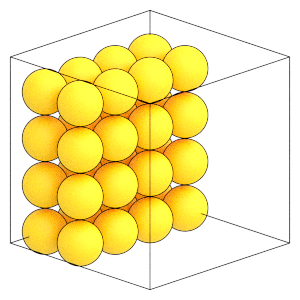

In [4]:
render(frame)

In [5]:
fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

In [6]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='lattice.gsd')

In [7]:
mc = hoomd.hpmc.integrate.Sphere()
mc.shape['A'] = dict(diameter=2)

simulation.operations.integrator = mc

In [8]:
initial_snapshot = simulation.state.get_snapshot

In [9]:
simulation.run(10e3)
mc.translate_moves

(1158408, 121592)

In [10]:
mc.overlaps

0

In [11]:
N_particles

32

In [12]:
mc.type_shapes

[{'type': 'Sphere', 'diameter': 2}]

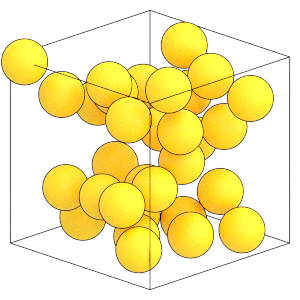

In [13]:
final_snapshot = simulation.state.get_snapshot()
render(final_snapshot)

In [14]:
fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='random.gsd')

In [15]:
del(simulation)

In [16]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='random.gsd')

In [17]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [18]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion.gsd', trigger=hoomd.trigger.Periodic(500), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [19]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    max_translation_move=1,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [20]:
rho = simulation.state.N_particles / simulation.state.box.volume
rho 

0.05398985726375124

In [21]:
target_volume_fraction = 0.01
volume_particle = (4 / 3) * math.pi * (1**3)
target_rho = target_volume_fraction / volume_particle
target_rho

0.0023873241463784303

In [22]:
final_rho = target_rho
final_volume = simulation.state.N_particles / final_rho
final_volume

13404.12865531645

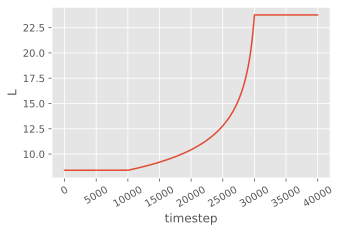

In [23]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)

steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

In [24]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp, 
)
simulation.operations.updaters.append(box_resize)

In [25]:
simulation.run(20001)
mc.overlaps

0

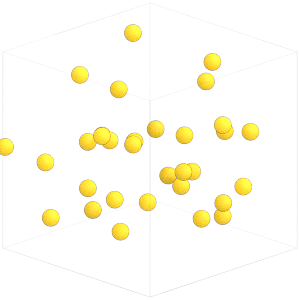

In [26]:
render(simulation.state.get_snapshot())

In [27]:
simulation.run(100)

In [28]:
gsd_writer.flush()

In [29]:
del(simulation)

In [30]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_expansion.gsd')

In [31]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [32]:
fn = os.path.join(os.getcwd(), 'trajectory_compression.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_compression.gsd', trigger=hoomd.trigger.Periodic(500), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [33]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    max_translation_move=1,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [34]:
rho = simulation.state.N_particles / simulation.state.box.volume
rho 

0.0024131252980993797

In [35]:
target_volume_fraction = 0.56
volume_particle = (4 / 3) * math.pi * (1**3)
target_rho = target_volume_fraction / volume_particle
target_rho

0.1336901521971921

In [36]:
final_rho = target_rho
final_volume = simulation.state.N_particles / final_rho
final_volume

239.35944027350803

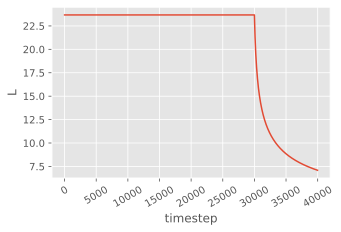

In [37]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=15_000,
)

steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

In [38]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp, 
)
simulation.operations.updaters.append(box_resize)

In [39]:
simulation.run(15001)
mc.overlaps

9

In [40]:
simulation.operations.updaters.remove(box_resize)
simulation.operations.tuners.remove(tune)
simulation.run(2e5)
mc.overlaps

0

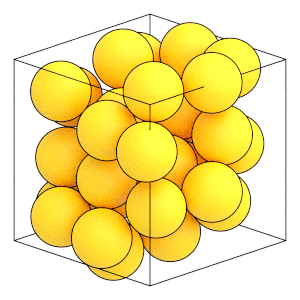

In [41]:
render(simulation.state.get_snapshot())

In [42]:
current_VF = (simulation.state.N_particles * volume_particle) / simulation.state.box.volume
current_VF

0.5599999999999995

In [43]:
gsd_writer.flush()

In [44]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot, particles=None, is_solid=None):

    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]

    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)

def render_movie(frames, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render(frames[0], particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render(f, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = numpy.ones(shape=(im.height, im.width, 3), dtype=numpy.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [45]:
traj_exp = gsd.hoomd.open('trajectory_expansion.gsd')
len(traj_exp)

40

In [46]:
traj_cmp = gsd.hoomd.open('trajectory_compression.gsd')
len(traj_cmp)

430

In [47]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj_cmp:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

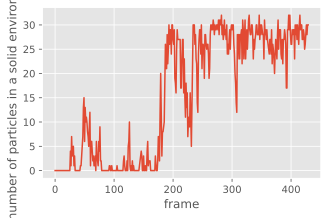

In [48]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

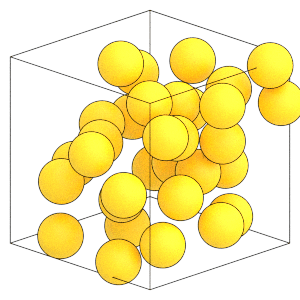

In [54]:
render_movie(traj_exp[0:40:4])

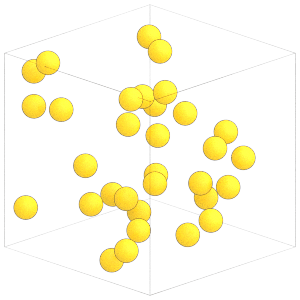

In [53]:
render_movie(traj_cmp[0:430:10])